# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Problem Definition ----

The main purpose of this project is to help HR and Talent acquisition teams to predict the salary based on various factors like job type, degree, major, industry, years of experience and miles from metropolis.

In [73]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb


from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")


__author__ = "Unnimaya Balachandran"
__email__ = "unnimayabudayam@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [74]:
train_feature_df = pd.read_csv('train_features.csv')
test_feature_df  = pd.read_csv('test_features.csv')
train_target_df  = pd.read_csv('train_salaries.csv')


#### Examine the Data

In [75]:
train_feature_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [76]:
train_target_df.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


#### Combine Feature and Target Data 

In [77]:
train_data_df = pd.merge(train_feature_df,train_target_df, on ='jobId')

In [78]:
train_data_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


#### Use .info() to see length and dtypes

In [79]:
train_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [80]:
train_data_df.shape

(1000000, 9)

### ---- 3 Clean the data ----

#### Check Missing Data

In [81]:
train_data_df.isnull().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

#### Check for Duplicates

In [82]:
train_data_df.duplicated().sum()

0

Entries with zero salary do not appear to be volunteer positions. We are confident that they are instances of missing/corrupt data and should be removed from the training set.

In [83]:
train_data_df[train_data_df['salary'] <= 0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [84]:
train_data_df = train_data_df[train_data_df['salary'] > 0]
train_data_df.shape


(999995, 9)

### ---- 4 Explore the data (EDA) ----

#### Identify Numerical and Categorical Variables

In [85]:
train_feature_df.columns

Index(['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis'],
      dtype='object')

In [86]:
numeric_cols = ['yearsExperience', 'milesFromMetropolis']

In [87]:
categorical_cols = ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry']

#### Summarize numerical and categorical variables separately

In [88]:
train_data_df.describe(include = [np.number])

,yearsExperience,milesFromMetropolis,salary
count,999995.000000,999995.000000,999995.000000
mean,11.992407,49.529381,116.062398
std,7.212390,28.877721,38.717163
min,0.000000,0.000000,17.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


In [89]:
train_data_df.describe(include = ['O'])

,jobId,companyId,jobType,degree,major,industry
count,999995,999995,999995,999995,999995,999995
unique,999995,63,8,5,9,7
top,JOB1362684764166,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236975,532353,143205


#### Visualize target Variable(Salary)

<Figure size 1008x432 with 0 Axes>

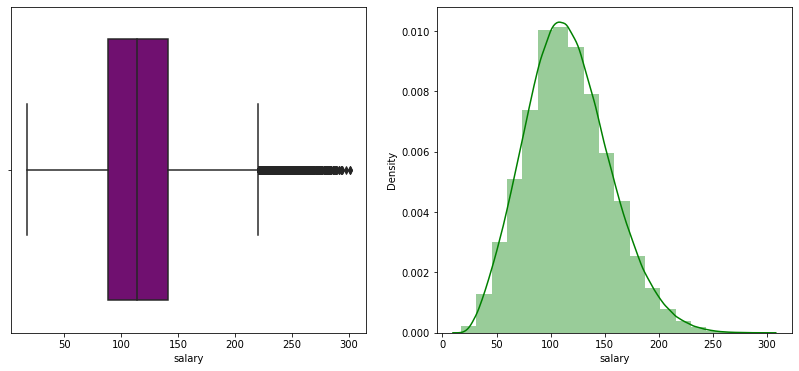

In [90]:
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
sns.boxplot(train_data_df.salary,color = 'purple')
plt.subplot(1,2,2)
sns.distplot(train_data_df.salary, bins=20,color ='green')
plt.show()

#### Use IQR rule to identify potential outliers

In [91]:
stat = train_data_df.salary.describe()
print(stat)
IQR = stat['75%'] - stat['25%']
high_sal = stat['75%'] + 1.5 * IQR
low_sal = stat['25%'] - 1.5 * IQR
print('The upper and lower bounds for suspected outliers are {} and {}.'.format(high_sal, low_sal))

count    999995.000000
mean        116.062398
std          38.717163
min          17.000000
25%          88.000000
50%         114.000000
75%         141.000000
max         301.000000
Name: salary, dtype: float64
The upper and lower bounds for suspected outliers are 220.5 and 8.5.


In [92]:
#check potential outlier above upper bound
train_data_df[train_data_df['salary'] > high_sal ]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
266,JOB1362684407953,COMP30,CEO,MASTERS,BIOLOGY,OIL,23,60,223
362,JOB1362684408049,COMP38,CTO,MASTERS,NONE,HEALTH,24,3,223
560,JOB1362684408247,COMP53,CEO,MASTERS,BIOLOGY,WEB,22,7,248
670,JOB1362684408357,COMP26,CEO,MASTERS,MATH,AUTO,23,9,240
719,JOB1362684408406,COMP54,VICE_PRESIDENT,DOCTORAL,BIOLOGY,OIL,21,14,225
...,...,...,...,...,...,...,...,...,...
998516,JOB1362685406203,COMP29,CFO,MASTERS,ENGINEERING,WEB,14,46,227
999249,JOB1362685406936,COMP30,CEO,NONE,NONE,OIL,17,10,223
999280,JOB1362685406967,COMP2,CFO,BACHELORS,BUSINESS,SERVICE,21,0,228
999670,JOB1362685407357,COMP20,CEO,DOCTORAL,LITERATURE,SERVICE,24,14,233


In [93]:
# Check most suspicious potential outliers above upper bound
train_data_df.loc[train_data_df['salary'] > high_sal, 'jobType'].value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

In [94]:
train_data_df.loc[(train_data_df['salary'] > high_sal) & (train_data_df['jobType'] =='JUNIOR'),'industry'].value_counts()

OIL        11
FINANCE     8
WEB         1
Name: industry, dtype: int64

The high-salary potential outliers all appear to be legitimate data. Most roles are C-level executive roles and the junior positions are in industries that are well known for high salaries (oil, finance). We determine these entries to be legitimate and will not remove them.

#### Visually exploring the relationship between the feature variables and the target

In [95]:
def plot_features(df,column):
    plt.figure(figsize =(14,4))
    if df[column].dtype != 'int64':
        plt.subplot(1,2,1)
        mean = df.groupby(column)['salary'].mean()
        df[column] = df[column].astype("category")
        levels = mean.sort_values().index.tolist()
        df[column].cat.reorder_categories(levels, inplace=True)
        mean.sort_values().plot(kind="bar", color="green")
        plt.xticks(rotation=45)
        plt.ylabel("The average salary for" + " " + column.capitalize())
        plt.title("Average salary versus" + ' ' + column)
        plt.subplot(1,2,2)
        sns.violinplot(x=column, y='salary', data=df)
        plt.xticks(rotation=45)
        plt.ylabel("Salaries")
        plt.savefig('salary_vs_' + column + '.png')
        plt.show()
        
    if df[column].dtype == 'int64':
        mean_p = df.groupby(column)['salary'].mean()
        std_p = train_data_df.groupby(column)['salary'].std()
        mean_p.plot()
        plt.fill_between(range(len(std_p.index)), mean_p.values + std_p.values, mean_p.values - std_p.values, alpha=0.1)
        plt.savefig('salary_vs_' + column + '.png')

In [96]:
train_data_features = ['jobType', 'degree', 'major', 'industry', 'yearsExperience','milesFromMetropolis']
train_data_cat_features = ['jobType', 'degree', 'major', 'industry'] 
train_data_num_features = []

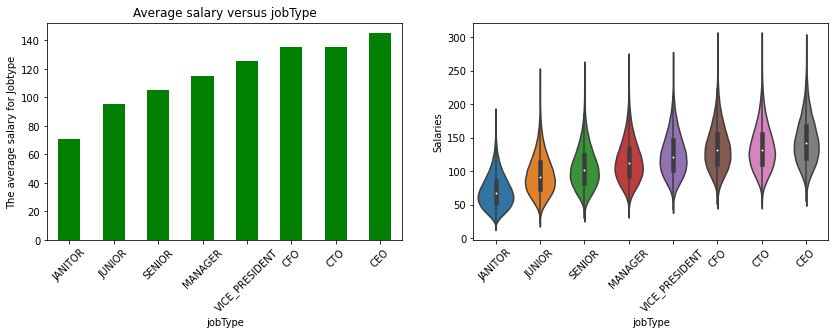

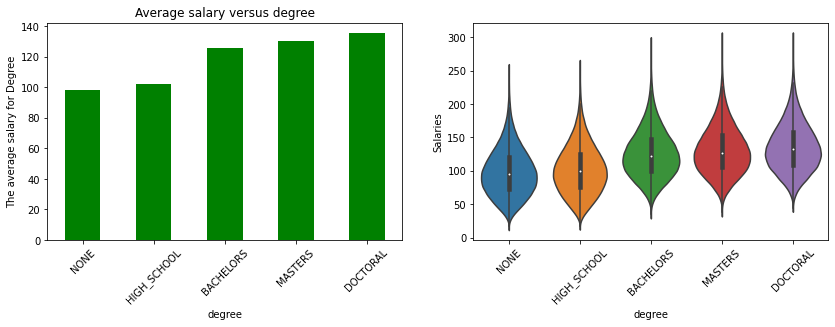

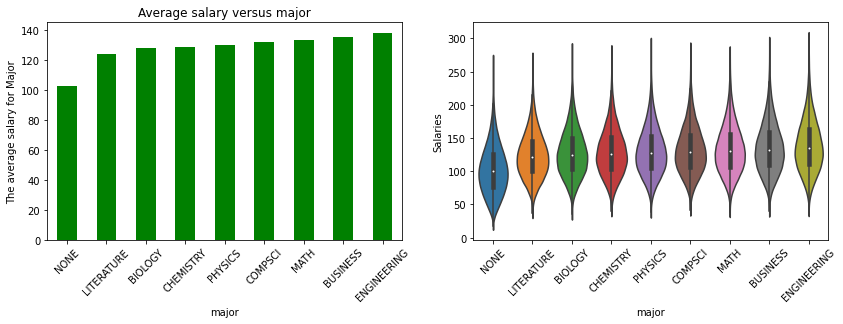

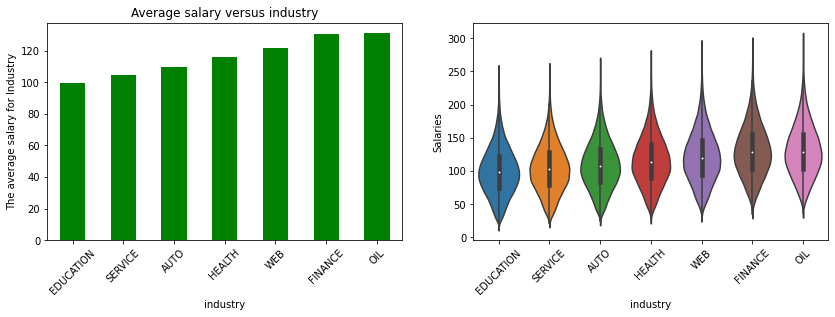

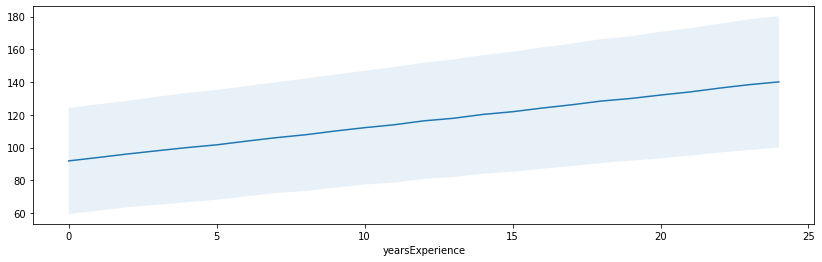

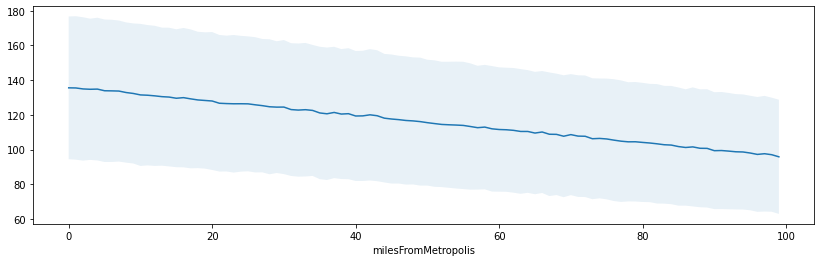

In [97]:
for feature in train_data_features:
    plot_features(train_data_df, feature)

From visualizations we came to the following results:-
    - There is a clear positive correlation between job type and salary
    - More advanced degrees tend to correspond to higher salaries
    - People with majors of engineering, business and math generally have higher salaries
    - As for industries, oil, finance and web industries generally pay better
    - In general, there is a clear correlation between salary and years of experience
    - In general, salaries decrease with the distance to metropolis

#### Label encoding for categorical variable to replace the value with mean salary fot that category

In [98]:
def encode_label(data, column):
    dict = {}
    cat_list = data[column].cat.categories.tolist()
    for cat in cat_list:
        dict[cat] = data[data[column] == cat]['salary'].mean()
    data[column] = data[column].map(dict)

In [99]:
train_data_copy = train_data_df.copy()
for column in train_data_copy.columns:
    if train_data_copy[column].dtype.name == 'category':
        encode_label(train_data_copy, column)
        train_data_copy[column] = train_data_copy[column].astype('float')

####  Check for correlations between selected features and response

<Figure size 1008x432 with 0 Axes>

(7.5, -0.5)

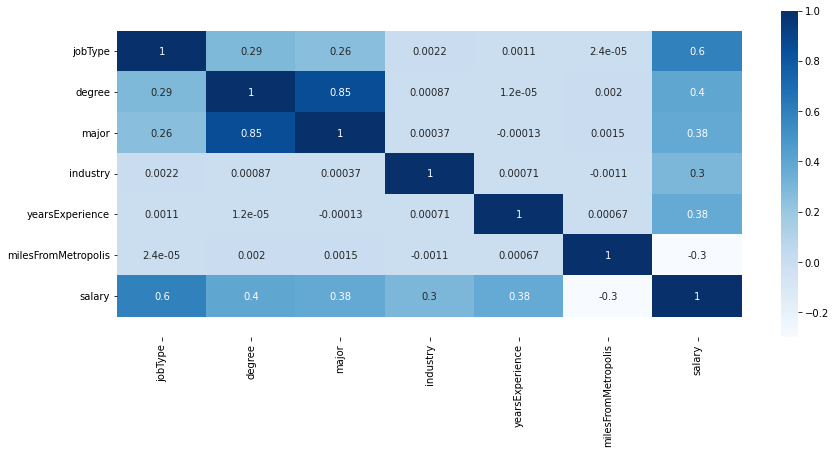

In [100]:
corrmat = train_data_copy.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(14,6))
ax = sns.heatmap(train_data_copy[top_corr_features].corr(), annot=True, cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.savefig("correlation.png")
plt.show()

We see that jobType is most strongly correlated with salary, followed by degree, major, and yearsExperience.

Among the features, we see that degree and major have a strong degree of correlation and jobType has a moderate degree of correlation with both degree and major.

### ---- 5 Establish a baseline ----

#### Selected a reasonable metric (MSE in this case), created an extremely simple model and measure its efficacy


In [101]:
mse = mean_squared_error(train_data_copy['jobType'],train_data_copy['salary'])
mse

963.9252996562975

### ---- 6 Hypothesize solution ----

In [102]:
#Linear Regression
from sklearn.linear_model import LinearRegression
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
# Extreme Gradient Boost
from sklearn.ensemble import GradientBoostingRegressor #Fast and high performance

Based on the Exploratory Data Analysis performed, selected three regression models,linear regression,Random Forest regression and Gradient Boost regression. Linear Regression model is basic and straight forward. Low variance and low bias are the factors considered to select Random forest. Gradient boost has been selected for fast and high performance.

## Part 3 - DEVELOP

#### Make sure that data is ready for modeling and created new features needed to potentially enhance the variables

### ---- 7 Engineer features  ----

In [103]:
cat_variables  = ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry'] 
num_variables  = ['yearsExperience', 'milesFromMetropolis', 'salary']
feat_variables = ['jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis']

In [104]:
train_data_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


#### One-hot Encoding for nominal variables

In [105]:
one_hot_var = ['jobType', 'major', 'industry']
train_data_dum = pd.get_dummies(train_data_df[one_hot_var], drop_first=True)
train_data_dum.head()

,jobType_JUNIOR,jobType_SENIOR,jobType_MANAGER,jobType_VICE_PRESIDENT,jobType_CFO,jobType_CTO,jobType_CEO,major_LITERATURE,major_BIOLOGY,major_CHEMISTRY,major_PHYSICS,major_COMPSCI,major_MATH,major_BUSINESS,major_ENGINEERING,industry_SERVICE,industry_AUTO,industry_HEALTH,industry_WEB,industry_FINANCE,industry_OIL
0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


#### Label encoder for ordinal varibles - degree

In [106]:
train_data_df['degree'].replace({ 'NONE': 1, 'HIGH_SCHOOL': 2, 'BACHELORS': 3, 'MASTERS':4, 'DOCTORAL': 5}, inplace=True )
train_data_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,4,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,2,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,5,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,5,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,3,PHYSICS,FINANCE,8,16,163


In [107]:
Y = train_data_df.iloc[:,-1]
Y.head()

0    130
1    101
2    137
3    142
4    163
Name: salary, dtype: int64

In [108]:
X = train_data_df.iloc[:,:-1]
X.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,4,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,2,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,5,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,5,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,3,PHYSICS,FINANCE,8,16


In [109]:
X = pd.concat([X,train_data_dum],axis = 1)
X = X.drop(['jobId','companyId','jobType','major','industry'],axis=1)

In [110]:
X.head()

,degree,yearsExperience,milesFromMetropolis,jobType_JUNIOR,jobType_SENIOR,jobType_MANAGER,jobType_VICE_PRESIDENT,jobType_CFO,jobType_CTO,jobType_CEO,major_LITERATURE,major_BIOLOGY,major_CHEMISTRY,major_PHYSICS,major_COMPSCI,major_MATH,major_BUSINESS,major_ENGINEERING,industry_SERVICE,industry_AUTO,industry_HEALTH,industry_WEB,industry_FINANCE,industry_OIL
0,4,10,83,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
1,2,3,73,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,5,10,38,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,5,8,17,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,3,8,16,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


#### train-test split

In [111]:
X_train, X_test, y_train, y_test=train_test_split(X, Y, test_size=0.2, random_state=42)

### ---- 8 Create models ----

#### Linear Regression

In [112]:
lin_reg   = LinearRegression()
lin_model = lin_reg.fit(X_train, y_train)
lin_pred  = lin_model.predict(X_test)

In [113]:
lin_reg_mse=mean_squared_error(y_test, lin_pred)
lin_reg_mse

383.4560710070862

#### Random Forest Regression

In [114]:
ranfor_reg = RandomForestRegressor(n_estimators=150, n_jobs=2, max_depth=30, min_samples_split=60, max_features='auto', verbose=0)

In [115]:
ranfor_model = ranfor_reg.fit(X_train, y_train)
ranfor_pred  = ranfor_model.predict(X_test)

In [116]:
ranfor_mse = mean_squared_error(y_test, ranfor_pred)
ranfor_mse

366.5210725972064

In [117]:
ranfor_mse

366.5210725972064

#### Gradient Boosting Regressor

In [118]:
# Gradient Boosting regressor model
gr_reg     = GradientBoostingRegressor(n_estimators=160, max_depth=6, loss='ls', verbose=0 )
gr_model   = gr_reg.fit(X_train,y_train)
gr_predict = gr_model.predict(X_test)

In [119]:
gr_mse = mean_squared_error(y_test, gr_predict)
gr_mse

357.5458404776882

### ---- 9 Test models ----

#### Performed 5-fold cross validation on models and measured MSE

#### Linear Regression with cross validation

In [120]:
lin_reg_nmse = cross_val_score(lin_reg, X_test, y_test,n_jobs=2, cv=5, scoring="neg_mean_squared_error")

In [121]:
linreg_mse_cv = -1.0 * np.mean(lin_reg_nmse)
linreg_mse_cv

383.5177191567814

#### Random Forest with Cross validation

In [122]:
ranfor_nmse = cross_val_score(ranfor_reg, X_test, y_test,n_jobs=2,cv=5, scoring="neg_mean_squared_error")
ranfor_mse_cv = -1.0 * np.mean(ranfor_nmse)
ranfor_mse_cv

378.11752706893606

#### Gradient Boosting with Cross Validation

In [123]:
#Gradient boost with Cross_val
gr_nmse = cross_val_score(gr_reg, X_test, y_test, cv=5, n_jobs=2, scoring='neg_mean_squared_error' )
gr_mse_cv=-1*gr_nmse.mean()
gr_mse_cv

360.12187839282456

### ---- 10 Select best model  ----

#### Select the model with the lowest error as your "prodcuction" model

In [124]:
results = {
    'Linear Regression' : [round(lin_reg_mse,2), round(linreg_mse_cv,2)],
    'Random Forest' : [round(ranfor_mse,2), round(ranfor_mse_cv,2)],
    'Gradient Boost' : [round(gr_mse,2), round(gr_mse_cv,2)]
}                                   
result_df = pd.DataFrame(results, index = ['Without Cross_val', 'With Cross_val'],)
result_df

,Linear Regression,Random Forest,Gradient Boost
Without Cross_val,383.46,366.52,357.55
With Cross_val,383.52,378.12,360.12


Selected Gradient Boost model as it has the low mean squared error compared to other models(Linear regression and Random Forest).

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [125]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

test_data = pd.read_csv("test_features.csv")

test_data.isnull().sum()
test_data.duplicated().sum()

# One-hot encoding for nominal variables
one_hot_var = ['jobType', 'major', 'industry']
test_data_dum = pd.get_dummies(test_data[one_hot_var], drop_first=True)

#Label encoder for ordinal varibles - degree
test_data['degree'].replace({ 'NONE': 1, 'HIGH_SCHOOL': 2, 'BACHELORS': 3, 'MASTERS':4, 'DOCTORAL': 5}, inplace=True )

test_data = pd.concat([test_data, test_data_dum], axis=1)
test_df = test_data.drop(['jobId','companyId', 'jobType', 'major', 'industry'], axis=1)
test_df.head()

gr_reg.fit(X_test,y_test)

#Run the prediction
test_pred = gr_reg.predict(test_df)


jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64

0

,degree,yearsExperience,milesFromMetropolis,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,major_BUSINESS,major_CHEMISTRY,major_COMPSCI,major_ENGINEERING,major_LITERATURE,major_MATH,major_NONE,major_PHYSICS,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,2,22,73,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,1,20,47,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,4,17,9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,2,14,96,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,5,10,44,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=6,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=160,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [126]:
prediction_df= pd.DataFrame(test_pred,columns=['Predicted Salaries'])
prediction_df.head(20)

,Predicted Salaries
0,132.804846
1,115.398116
2,139.610329
3,113.334325
4,134.106317
5,100.294573
6,143.974784
7,106.053407
8,126.990013
9,112.666850


In [127]:
predicted_data = pd.concat([test_feature_df['jobId'], prediction_df], axis=1)
predicted_data['Predicted Salaries']=predicted_data['Predicted Salaries'].apply(np.ceil)
predicted_data.head(20)

,jobId,Predicted Salaries
0,JOB1362685407687,133.0
1,JOB1362685407688,116.0
2,JOB1362685407689,140.0
3,JOB1362685407690,114.0
4,JOB1362685407691,135.0
5,JOB1362685407692,101.0
6,JOB1362685407693,144.0
7,JOB1362685407694,107.0
8,JOB1362685407695,127.0
9,JOB1362685407696,113.0


### ---- 12 Deploy solution ----

In [128]:
#saved the prediction from test data to *.csv file
predicted_data.to_csv('Predicted_salaries.csv',index=False )

In [129]:
feature_importances = pd.DataFrame({'Features':test_df.columns, 'Importance':gr_reg.feature_importances_})

In [130]:
feature_importances.sort_values(by='Importance', ascending=False, inplace=True) # sort features by descending importance

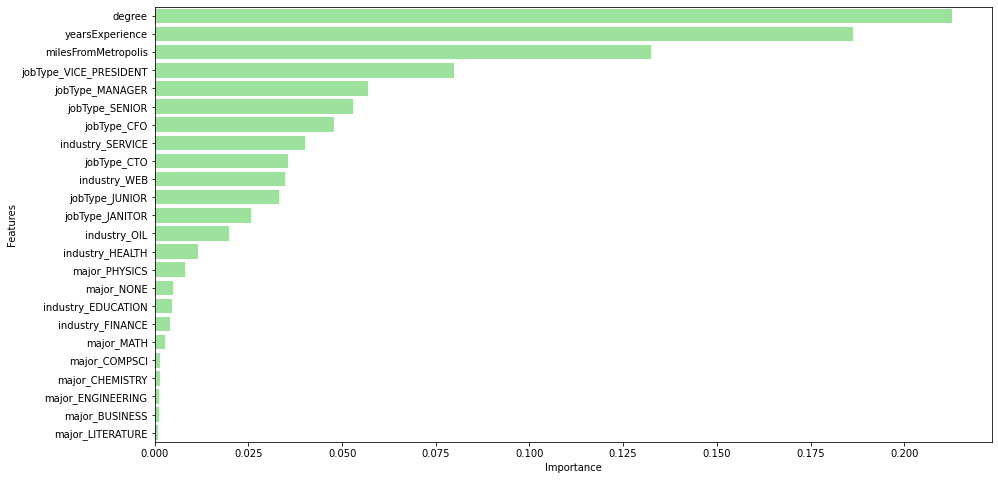

In [132]:
plt.figure(figsize=(15,8))
sns.barplot(x='Importance', y='Features',color= 'lightgreen',data=feature_importances)
plt.savefig("feature_importance.png")
plt.show();